<a href="https://colab.research.google.com/github/ConstanzaSchibber/capstone_colors/blob/main/notebooks/2_Model_B_for_color_identification_LLM_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model B: Identifying CIELAB Shade with Multimodal Large Language Model `Claude`

This notebook demonstrates the use of Claude, a multimodal large language model, to identify and analyze the CIELAB color values of makeup shades from images. CIELAB is a color space that closely represents human vision, making it ideal for precise color analysis in the cosmetics industry.

We'll explore how Claude can:

1. Process and interpret images of makeup products
2. Estimate CIELAB color values for lipsticks, blush, and other cosmetics
3. Provide color analysis and descriptions

This approach combines advanced computer vision capabilities with natural language processing, offering a powerful tool for color matching and product development in the beauty industry.

# Libraries

In [ ]:
from IPython.display import Image

In [ ]:
import cv2
import numpy as np
import pandas as pd
import glob
from PIL import Image
import time

In [ ]:
!pip install anthropic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 891.5/891.5 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.5 MB/s eta 0:00:00


In [ ]:
import anthropic
import os

In [ ]:
import base64
import requests
import os
from PIL import Image
from io import BytesIO

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive

# Mount Google Drive to access files stored there
# The 'force_remount=True' option ensures that the drive is remounted even if it is already mounted
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Load Metadata

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/data_5_cluster_output_v3.csv')
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'category', 'joined', 'brand', 'product',
       'shade', 'img_url', 'shade_description_original', 'id', 'validation',
       'img_name', 'mean_lab', 'peak_lab', 'sd_color', 'ground_truth',
       'ground_truth_CIELAB', 'diff_lab', 'diff_peak_black', 'diff_peak_white',
       'mean_lab_2', 'peak_lab_2', 'diff_lab_2', 'mean_lab_3', 'peak_lab_3',
       'diff_lab_3'],
      dtype='object')

In [ ]:
key = ['YOUR_API_KEY'] #from Antropic

# Testing an Individual Image

In [ ]:
i=0

In [ ]:
path = '/content/drive/MyDrive/makeup_img/' + str(df.img_name[i])

In [ ]:
def resize_image(image_path, max_size=(150, 150)):
    with Image.open(image_path) as img:
        img.thumbnail(max_size)
        buffered = BytesIO()
        img.save(buffered, format="JPEG")
        return buffered.getvalue()

def encode_image(image_bytes):
    return base64.b64encode(image_bytes).decode('utf-8')

In [ ]:
# Path to your image file
image_path = path

# Resize and encode the image
resized_image = resize_image(image_path)
base64_image = encode_image(resized_image)

In [ ]:
prompt = 'This image is of makeup, ' + str(df.category[i]) + '. The image may have the container in the image. Provide the approximate CIELAB color for the makeup product, not the container. Only respond with the CIELAB color in a python list format.'

In [ ]:
# Your API key and the API endpoint
api_key = key
api_url = "https://api.anthropic.com/v1/messages"

# Headers for the API request
headers = {
    "Content-Type": "application/json",
    "X-API-Key": api_key,
    "anthropic-version": "2023-06-01"  # Add this line

}

In [ ]:
# Data for the API request
data = {
    "model": "claude-3-opus-20240229",
    "max_tokens": 1000,
    "messages": [
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "source": {
                        "type": "base64",
                        "media_type": "image/jpeg",
                        "data": base64_image
                    }
                },
                {
                    "type": "text",
                    "text": prompt
                }
            ]
        }
    ]
}

# Sending the request to the API
response = requests.post(api_url, json=data, headers=headers)

# Printing the response
print(response.json())

{'id': 'msg_01SFComBNKuLEJgFdXjsdqEx', 'type': 'message', 'role': 'assistant', 'model': 'claude-3-opus-20240229', 'content': [{'type': 'text', 'text': '[44.0, 28.0, 18.0]'}], 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'input_tokens': 81, 'output_tokens': 18}}


In [ ]:
response.json()['content'][0]['text']

'[45, 50, 30]'

In [ ]:
df.ground_truth_CIELAB[i]

'[38.19553169 47.68982678 36.88843393]'

In [ ]:
df.mean_lab_3[i]

'[55.11311510009591, 17.24767335970273, 16.280531174648672]'

# Prompt Engineering

Prompt engineering is the process of crafting and refining inputs (prompts) given to a large language model (LLM), to achieve the desired output. It is crucial because the quality of the output is heavily dependent on the clarity, specificity, and context provided in the prompt. Effective prompt engineering ensures that models perform tasks accurately and efficiently, minimizing errors and improving the relevance of the responses.

## Prompt 1

The initial prompt was straightforward but lacked specificity. By explicitly mentioning the possibility of the container being in the image and directing the model to focus only on the makeup product, it helps narrow down the model's focus, improving the accuracy of the color extraction.

Prompt: `This image is of makeup, [input type of product]. The image may have the container. Provide the approximate CIELAB color for the makeup product, not the container. Only respond with the CIELAB color in a python list format. `
## Prompt 2 (Used in Round 1)

The previous prompt was revised to make the instructions clearer by emphasizing the task of identifying the makeup product's color and ignoring the container. The added context helps the model to better understand the task and reduces the chances of errors in color identification.

Prompt:  `Your task is to identify the CIELAB color (or the closest approximation) of the makeup product [input type of product] in the image. The image may include the makeup container, but focus solely on the color of the makeup itself. Respond only with the CIELAB color in a Python list format. `


## Prompt 3 (Used in Round 2)

After validation, improvement of the prompt was necessary. The changes in this prompt were made to provide more detailed instructions for different types of makeup products, ensuring that the model accurately identifies the specific area to focus on (e.g., the tip of a lipliner or the blush itself). The additional explanation of the CIELAB color format was included to guide the model in providing the response in the correct format because in the first round, some CIELAB colors were in the incorrect range.

- Prompt for lipstick: `Your task is to identify the CIELAB color (or the closest approximation) of the lipstick in the image. Lipsticks are in a container, but focus solely on the color of the lipstick itself. Respond only with the CIELAB color in a Python list format. For CIELAB color, L is between 0 and 100, a and b are between -128 and 128.`

- Prompt for lipliner: `Your task is to identify the CIELAB color (or the closest approximation) of the pencil in the image. I need the color of the pencil which will be in the tip of the pencil. Respond only with the CIELAB color in a Python list format. For CIELAB color, L is between 0 and 100, a and b are between -128 and 128.`

- Prompt for blush: `Your task is to identify the CIELAB color (or the closest approximation) of the blush or foundation in the image. Makeup sometimes comes in containers, but focus solely on the color of the makeup itself. Respond only with the CIELAB color in a Python list format. For CIELAB color, L is between 0 and 100, a and b are between -128 and 128.`

- Prompt for lipgloss': `Your task is to identify the CIELAB color (or the closest approximation) of the lipgloss in the image. I need the color of the lipgloss, not the container. Respond only with the CIELAB color in a Python list format. For CIELAB color, L is between 0 and 100, a and b are between -128 and 128.`

# Round 1: Scaling Up

The function `resize_image` resizes an image to fit within a specified maximum size and converts it to JPEG format. It returns the image data as a byte stream.

- Open the Image: The image is loaded from the given file path using Image.open(image_path).
- Resize the Image: The img.thumbnail(max_size) method resizes the image, keeping its aspect ratio intact, so it fits within the max_size dimensions (150x150 by default). This is to improve the speed of the API and because it will consume less tokens, making it cheaper.
- Convert to RGB (if necessary): The function checks if the image mode is not "RGB". If it's in another mode (e.g., "RGBA" or "P"), it converts the image to "RGB", which is necessary because JPEG doesn't support other modes like "RGBA" or "P".
- Save as JPEG: The image is saved to a BytesIO buffer in JPEG format.
Return the Byte Stream: Finally, the function returns the JPEG image data as a byte stream, which can be used directly (e.g., for saving to a file, sending over a network, etc.).

In [ ]:
def resize_image(image_path, max_size=(150, 150)):
    with Image.open(image_path) as img:
        img.thumbnail(max_size)

        # Convert for png
        if img.mode != "RGB":
          img = img.convert("RGB")

        buffered = BytesIO()
        img.save(buffered, format="JPEG")
        return buffered.getvalue()

The function `encode_image` converts image data into a Base64-encoded string, such that images can be read by the Claude API.

- Base64 Encoding: The function takes image_bytes as input, which is the raw binary data of an image.
- Encode to Base64: It uses base64.b64encode(image_bytes) to encode the binary image data into a Base64 format, which is a text representation of binary data.
Decode to String: The result is then decoded from bytes to a UTF-8 string using .decode('utf-8').
- Return the Encoded String: Finally, it returns the Base64-encoded string, which can be used for embedding images in HTML, JSON, or other text-based formats.


In [ ]:
def encode_image(image_bytes):
    return base64.b64encode(image_bytes).decode('utf-8')

The function `apply_claude` function processes an image by resizing and encoding it, then sends a request to the Claude API to identify the CIELAB color of a makeup product in the image. It returns the color in a Python list format.


- Wait: The function starts by pausing for 12 seconds using time.sleep(12). This avoids hitting API rate limits of 5 requests per minute. See [rate limits](https://docs.anthropic.com/en/api/rate-limits).

- Resize and Encode the Image: The image is resized using `resize_image` and then encoded into a Base64 string using `encode_image`.
- Create the Prompt: A text prompt is generated, instructing the LLM to identify the CIELAB color of the makeup product in the image.
The category (e.g., "lipstick", "blush") is included in the prompt to specify the type of makeup.
- Prepare API Request Data: A dictionary data is created to structure the API request. The dictionary includes the model name, maximum tokens, and a message containing both the Base64-encoded image and the prompt.
- Send the Request: The request is sent to the API using requests.post(), with the data and headers passed as arguments.
- Return the Response: A python list with the CIELAB colors.


In [ ]:
def apply_claude(image_path, category, key):
    # wait
    time.sleep(12)
    # Resize and encode the image
    resized_image = resize_image(image_path)
    base64_image = encode_image(resized_image)



    # Your API key and the API endpoint
    api_key = key
    api_url = "https://api.anthropic.com/v1/messages"

    # Headers for the API request
    headers = {
      "Content-Type": "application/json",
      "X-API-Key": api_key,
      "anthropic-version": "2023-06-01"  # Add this line
      }

    # Prompt
    prompt = 'Your task is to identify the CIELAB color (or the closest approximation) of the makeup product' + '(' + category + ')' + 'in the image. The image may include the makeup container, but focus solely on the color of the makeup itself. Respond only with the CIELAB color in a Python list format.'

    # Data for the API request
    data = {
      "model": "claude-3-opus-20240229",
      "max_tokens": 1000,
      "messages": [
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "source": {
                        "type": "base64",
                        "media_type": "image/jpeg",
                        "data": base64_image
                    }
                },
                {
                    "type": "text",
                    "text": prompt
                }
            ]
          }
        ]
      }
    # Sending the request to the API
    response = requests.post(api_url, json=data, headers=headers)

    # Return response, list
    return response.json()#['content'][0]['text']

In [ ]:
df['Claude_CIELAB'] = pd.Series(dtype='object')

In [ ]:
for i in range(len(df)):
    path = '/content/drive/MyDrive/makeup_img/' + str(df.img_name[i])
    category = str(df.category[i])
    lab_claude = apply_claude(path, category, key)
    df.at[i, 'Claude_CIELAB'] = lab_claude

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [ ]:
df['Claude_message'] = df['Claude_CIELAB']

The response is in json format:

In [ ]:
df.loc[0, 'Claude_message']

{'id': 'msg_01CJPy4evToRqNqyaHyYCXLq',
 'type': 'message',
 'role': 'assistant',
 'model': 'claude-3-opus-20240229',
 'content': [{'type': 'text', 'text': '[35, 50, 40]'}],
 'stop_reason': 'end_turn',
 'stop_sequence': None,
 'usage': {'input_tokens': 112, 'output_tokens': 12}}

Below, I extract color list from json response

In [ ]:
df['Claude_CIELAB'] = df['Claude_message'].apply(lambda x: x['content'][0]['text'])

In [ ]:
df.loc[0, 'Claude_CIELAB']

'[35, 50, 40]'

Next, I write a function to test if all of the results in `Claude_CIELAB` are lists. One case, it is not a list, because the result when applying the function is `False`. For this particular object, Claude retuned `'Based on the lipstick color shown in the image, the closest CIELAB color approximation is:\n\n[37, 48, 34]'`, so I replace the color with the approximation provided in this message.

In [ ]:
def is_list(cell):
    try:
        ast.literal_eval(cell)
    except (SyntaxError, ValueError):
        return False
    return isinstance(ast.literal_eval(cell), list)

In [ ]:
df['is_list_LLM'] = df['Claude_CIELAB'].apply(is_list)

In [ ]:
df['is_list_LLM'].value_counts()/len(df)*100

,count
is_list_LLM,
True,99.802372
False,0.197628


In [ ]:
print(df[df.is_list_LLM == False].Claude_CIELAB)

155    Based on the lipstick color shown in the image...
Name: Claude_CIELAB, dtype: object


In [ ]:
df.Claude_message[155]

{'id': 'msg_01R3n5EDRAnnykQ6Tj84334L',
 'type': 'message',
 'role': 'assistant',
 'model': 'claude-3-opus-20240229',
 'content': [{'type': 'text',
   'text': 'Based on the lipstick color shown in the image, the closest CIELAB color approximation is:\n\n[37, 48, 34]'}],
 'stop_reason': 'end_turn',
 'stop_sequence': None,
 'usage': {'input_tokens': 113, 'output_tokens': 35}}

In [ ]:
# replace item 155
df.at[155, 'Claude_CIELAB'] = '[37, 48, 34]'

## Evaluating Model Results

In [ ]:
from sklearn.model_selection import train_test_split

# Split data into training and temporary sets (which will be further split into validation and test sets)
train_df, val_df = train_test_split(df, test_size=0.4, random_state=42)

print(f'Training set: {len(train_df)} samples')
print(f'Validation set: {len(val_df)} samples')

Training set: 303 samples
Validation set: 203 samples


Next, I identify the validation set and calculate the color distance to assess how close the estimate and the ground truth are.

To do this, I calculate Delta E (ΔE) which is a metric that quantifies the difference between two colors in the CIELAB color space. It calculates the distance between two points (representing colors) in the three-dimensional CIELAB space, where L* represents lightness, and a* and b* represent color-opponent dimensions.

Delta E is measured on a scale of 0 to 100. A lower ΔE value indicates that the two colors are very similar to each other, while a higher ΔE value suggests a more noticeable difference. Delta E is widely used in color matching and quality control to assess how close two colors are to being identical.

See also [color difference](https://en.wikipedia.org/wiki/Color_difference) in Wikipedia.

In [ ]:
from skimage.color import deltaE_ciede2000
import ast

In [ ]:
df['diff_llm_lab'] = pd.Series(dtype='object')

for i in range(len(df)):
  if df.ground_truth[i] == 1:
    diff = deltaE_ciede2000(ast.literal_eval(df.Claude_CIELAB[i]), list(map(float, df.ground_truth_CIELAB[i].strip('[]').split())))
    df.loc[i, 'diff_llm_lab'] = diff
  else:
    df.loc[i, 'diff_llm_lab'] = np.nan

In [ ]:
df.diff_llm_lab.mean()

15.763666199636756

Below is a histogram for Delta E each observation in the validation set. For a ΔE value of 0 indicates that the colors are identical, while values up to 10 suggest that the colors are similar. For color-matching applications, a threshold between 10 and 15 is generally effective (see [Color Difference Estimation](https://medium.com/@bhuwankhatiwada57/color-difference-estimation-using-cie-l-a-b-color-space-b415f97a6b94) and [Delta E - A Survey](https://wisotop.de/assets/2017/DeltaE-%20Survey-2.pdf))

The mean Delta E is 15.76 and the median, 12.7.

However, the optimal threshold varies depending on the specific application. With more time and funding, in the future, I could conduct tests or surveys with users to determine at what ΔE they perceive a difference as significant. This could help tailor the threshold to real-world preferences.

In [ ]:
df_val = pd.merge(df, val_df['id'], how='inner', on='id')
df_val.shape

(203, 30)

In [ ]:
df_val.diff_llm_lab.median()

12.788086337727593

In [ ]:
df_val.diff_llm_lab.mean()

16.45594936532544

<Axes: >

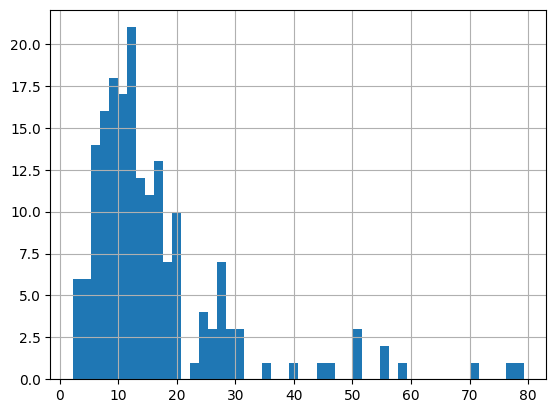

In [ ]:
df_val.diff_llm_lab.hist(bins=50)

We can also look at Delta E by product category. Below, we see that 'Delta E' is tends to be larger for 'lipstick', probably because lipstick is in a container and the color of the container is confounded with the color of the makeup.

Moreover, looking at the mean Delta E per product, blush has a mean of 15.4, lipgloss a mean of 15.5, while lipliner and lipstick have a higher Delta E of 20.8 and 17.5 respectively. The Delta E variance for these all product categories is considerably higher than it was with the Method 1.

/usr/local/lib/python3.10/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.10/dist-packages/numpy/lib/histograms.py:826: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


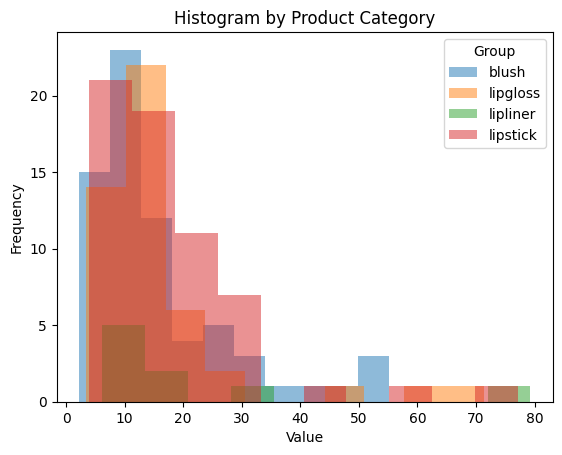

In [ ]:
# histogram with delta E by product category
# Create a figure and axis
fig, ax = plt.subplots()

# Group by the 'Group' column and plot a histogram for each group
for name, group in df_val.groupby('category'):
    ax.hist(group['diff_llm_lab'], bins=10, alpha=0.5, label=name)

# Add labels and legend
ax.set_xlabel('Value')
ax.set_ylabel('Frequency')
ax.set_title('Histogram by Product Category')
ax.legend(title='Group')

# Show the plot
plt.show()

In [ ]:
product_deltaE = df_val.diff_llm_lab.groupby(df_val.category).mean()
product_deltaE = product_deltaE.reset_index()
product_deltaE.columns = ['product category', 'Delta E']

print('Table: DeltaE (mean) by Product')
product_deltaE

Table: DeltaE (mean) by Product


,product category,Delta E
0,blush,15.468511
1,lipgloss,15.585626
2,lipliner,20.836473
3,lipstick,17.58097


In [ ]:
product_deltaE = df_val.diff_llm_lab.groupby(df_val.category).var()
product_deltaE = product_deltaE.reset_index()
product_deltaE.columns = ['product category', 'Delta E']

print('Table: DeltaE (SD) by Product')
product_deltaE

Table: DeltaE (SD) by Product


,product category,Delta E
0,blush,145.355918
1,lipgloss,169.088025
2,lipliner,533.017454
3,lipstick,143.483717


Looking at the cases in which the LLM did poorly, some values are outside of the range for CIELAB. The first item on the list has to be betwen 0 and 100, and in this case, many are outside of the range.

In [ ]:
df_val[df_val.diff_llm_lab > 40][['Claude_CIELAB', 'img_name']]

,Claude_CIELAB,img_name
28,"[25, 36, 30]",s2288447-av-01-zoom.jpg
46,"[152, 95, 97]",Loyal-Liquid-Blush.png
47,"[0.742, 0.309, 0.309]",chameleon-blush-4g.png
71,"[233, 157, 177]",ulta159.jpg
88,"[164, 117, 117]",ulta210.jpg
111,"[170, 100, 100]",el_sku_PKTJ16_640x640_1.jpg
119,"[220, 180, 170]",8960839.jpg
155,"[72.0, 60.0, 40.0]",s2243194-main-zoom.jpg
163,"[92.45, 9.39, 14.56]",s2243400-main-zoom.jpg
189,"[36.0, 55.0, 25.0]",s2427938-main-zoom.jpg


In [ ]:
#df.to_csv('/content/drive/My Drive/df_llm.csv')

In [ ]:
import seaborn as sns

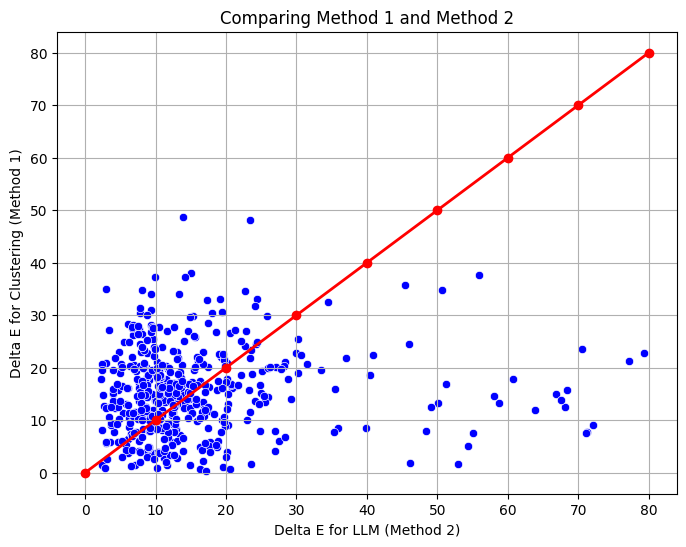

In [ ]:
# Create a scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_val, x=df['diff_llm_lab'], y=df['diff_lab_3'], color='blue')
plt.xlabel('Delta E for LLM (Method 2)')
plt.ylabel('Delta E for Clustering (Method 1)')
plt.title('Comparing Method 1 and Method 2')

# Points for the line
line_x = [0, 10, 20, 30, 40, 50, 60, 70, 80]
line_y = [0, 10, 20, 30, 40, 50, 60, 70, 80]

# Plot the line
plt.plot(line_x, line_y, color='red', linestyle='-', linewidth=2, marker='o')


plt.grid(True)
plt.show()

# Round 2: Improving the Prompt

Here, I add the prompt as an input of the function:

In [ ]:
def apply_claude(image_path, key, prompt_round):
    # wait
    time.sleep(12)
    # Resize and encode the image
    resized_image = resize_image(image_path)
    base64_image = encode_image(resized_image)



    # Your API key and the API endpoint
    api_key = key
    api_url = "https://api.anthropic.com/v1/messages"

    # Headers for the API request
    headers = {
      "Content-Type": "application/json",
      "X-API-Key": api_key,
      "anthropic-version": "2023-06-01"  # Add this line
      }

    # Prompt
    prompt = prompt_round

    # Data for the API request
    data = {
      "model": "claude-3-opus-20240229",
      "max_tokens": 1000,
      "messages": [
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "source": {
                        "type": "base64",
                        "media_type": "image/jpeg",
                        "data": base64_image
                    }
                },
                {
                    "type": "text",
                    "text": prompt
                }
            ]
          }
        ]
      }
    # Sending the request to the API
    response = requests.post(api_url, json=data, headers=headers)

    # Return response, list
    return response.json()#['content'][0]['text']

Now, I write a function to develop a more specific prompt for each product, to try to improve the color matching for lipstick and lipliner.

In [ ]:
def prompt_product(category):
  if category == 'lipstick':
    return 'Your task is to identify the CIELAB color (or the closest approximation) of the lipstick in the image. Lipsticks are in a container, but focus solely on the color of the lipstick itself. Respond only with the CIELAB color in a Python list format. For CIELAB color, L is between 0 and 100, a and b are between -128 and 128.'
  if category == 'lipliner':
    return 'Your task is to identify the CIELAB color (or the closest approximation) of the pencil in the image. I need the color of the pencil which will be in the tip of the pencil. Respond only with the CIELAB color in a Python list format. For CIELAB color, L is between 0 and 100, a and b are between -128 and 128.'
  if category == 'blush':
    return 'Your task is to identify the CIELAB color (or the closest approximation) of the blush or foundation in the image. Makeup sometimes comes in containers, but focus solely on the color of the makeup itself. Respond only with the CIELAB color in a Python list format. For CIELAB color, L is between 0 and 100, a and b are between -128 and 128.'
  if category == 'lipgloss':
    return 'Your task is to identify the CIELAB color (or the closest approximation) of the lipgloss in the image. I need the color of the lipgloss, not the container. Respond only with the CIELAB color in a Python list format. For CIELAB color, L is between 0 and 100, a and b are between -128 and 128.'


In [ ]:
df['Claude_message_2'] = pd.Series(dtype='object')

In [ ]:
for i in range(len(df)):
    path = '/content/drive/MyDrive/makeup_img/' + str(df.img_name[i])
    prompt3 = prompt_product(df.category[i])
    lab_claude = apply_claude(path, key, prompt3)
    df.at[i, 'Claude_message_2'] = lab_claude

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Below, I extract color list from json response

In [ ]:
df['Claude_CIELAB_2'] = df['Claude_message_2'].apply(lambda x: x['content'][0]['text'])

In [ ]:
df.loc[0, 'Claude_CIELAB_2']

'[60, 25, 20]'

Next, I apply the function `is_list` to check if all of the values in `Claude_CIELAB` are lists. In the previous round, there was one case that was not a list, but this time, all cases are lists.

In [ ]:
df['is_list_LLM_2'] = df['Claude_CIELAB'].apply(is_list)

In [ ]:
df['is_list_LLM_2'].value_counts()/len(df)*100

,count
is_list_LLM_2,
True,100.0


## Evaluating Model Results

Next, I identify the validation set and calculate the color distance to assess how close the estimate and the ground truth are.

To do this, I calculate Delta E (ΔE) which is a metric that quantifies the difference between two colors in the CIELAB color space. It calculates the distance between two points (representing colors) in the three-dimensional CIELAB space, where L* represents lightness, and a* and b* represent color-opponent dimensions.

Delta E is measured on a scale of 0 to 100. A lower ΔE value indicates that the two colors are very similar to each other, while a higher ΔE value suggests a more noticeable difference. Delta E is widely used in color matching and quality control to assess how close two colors are to being identical.

See also [color difference](https://en.wikipedia.org/wiki/Color_difference) in Wikipedia.

In [ ]:
df['diff_llm_lab_2'] = pd.Series(dtype='object')

for i in range(len(df)):
  if df.ground_truth[i] == 1:
    diff = deltaE_ciede2000(ast.literal_eval(df.Claude_CIELAB_2[i]), list(map(float, df.ground_truth_CIELAB[i].strip('[]').split())))
    df.loc[i, 'diff_llm_lab_2'] = diff
  else:
    df.loc[i, 'diff_llm_lab_2'] = np.nan

In [ ]:
df_val = pd.merge(df, val_df['id'], how='inner', on='id')
df_val.shape

(203, 34)

In the previous round, the mean for Delta E was 15, and now it went down to 11.

In [ ]:
df_val.diff_llm_lab_2.mean()

11.589597671391237

In [ ]:
df_val.diff_llm_lab.mean()

16.45594936532544

In [ ]:
(11.58-16.45)/16.45*100

-29.604863221884496

In [ ]:
(10.5-12.7)/12.7*100

-17.322834645669285

Below is a histogram for Delta E each observation in the validation set. For a ΔE value of 0 indicates that the colors are identical, while values up to 10 suggest that the colors are similar. For color-matching applications, a threshold between 10 and 15 is generally effective (see [Color Difference Estimation](https://medium.com/@bhuwankhatiwada57/color-difference-estimation-using-cie-l-a-b-color-space-b415f97a6b94) and [Delta E - A Survey](https://wisotop.de/assets/2017/DeltaE-%20Survey-2.pdf))

The mean Delta E is 11.8 and the median, 10.5. This means that 50% of the cases are below 10.5.

Compared to round 1, the mean decreased from 16.4 to 11.5, which is a 30% decrease. The median decreased from 12.8 to 10.56, which is a 17% decrease. Because the median and the mean are closer togehter now, we see there is a smaller number of cases in the tail of the distributions -- that is, cases predicted that were very far off from the ground truth color.


In [ ]:
df_val.diff_llm_lab_2.median()

10.560885107205264

In [ ]:
df_val.diff_llm_lab.median()

12.788086337727593

<Axes: >

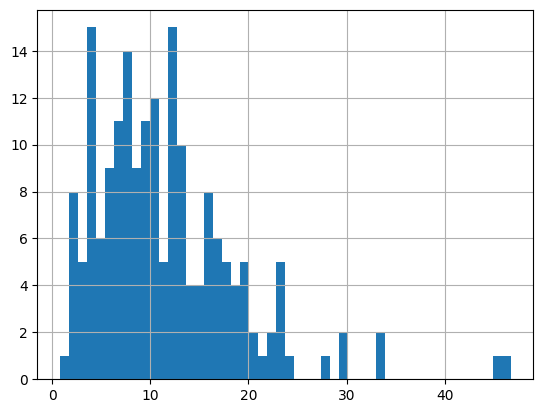

In [ ]:
df_val.diff_llm_lab_2.hist(bins=50)

We can also look at Delta E by product category. Below, we see that 'Delta E' is tends to be larger for 'lipstick', probably because lipstick is in a container and the color of the container is confounded with the color of the makeup.

Moreover, looking at the mean Delta E per product:

- Blush: Mean Delta E decreased from 15.4 to 9.5
- Lipgloss: Mean Delta E decreased fron 15.5 to 12.05
- Lipliner: Mean Delta E decreased from 20.8 to 13.3
- Lipstick: Mean Delta E decreased from 17.5 to 13.2

The Delta E variance for these all product categories decreased considerably.

/usr/local/lib/python3.10/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.10/dist-packages/numpy/lib/histograms.py:826: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


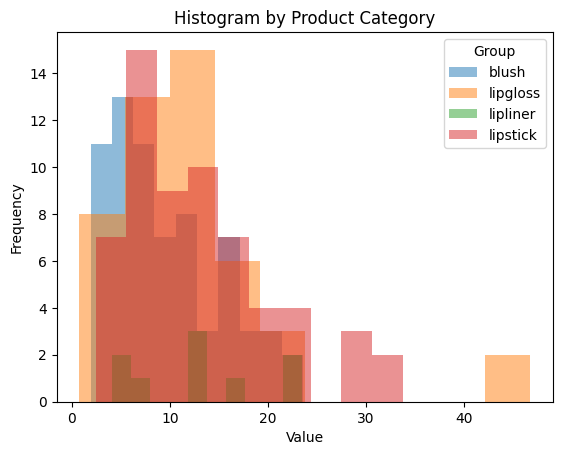

In [ ]:
# histogram with delta E by product category
# Create a figure and axis
fig, ax = plt.subplots()

# Group by the 'Group' column and plot a histogram for each group
for name, group in df_val.groupby('category'):
    ax.hist(group['diff_llm_lab_2'], bins=10, alpha=0.5, label=name)

# Add labels and legend
ax.set_xlabel('Value')
ax.set_ylabel('Frequency')
ax.set_title('Histogram by Product Category')
ax.legend(title='Group')

# Show the plot
plt.show()

In [ ]:
product_deltaE = df_val.diff_llm_lab_2.groupby(df_val.category).mean()
product_deltaE = product_deltaE.reset_index()
product_deltaE.columns = ['product category', 'Delta E']

print('Table: DeltaE (mean) by Product')
product_deltaE

Table: DeltaE (mean) by Product


,product category,Delta E
0,blush,9.588244
1,lipgloss,12.055304
2,lipliner,13.337426
3,lipstick,13.203915


In [ ]:
product_deltaE = df_val.diff_llm_lab_2.groupby(df_val.category).var()
product_deltaE = product_deltaE.reset_index()
product_deltaE.columns = ['product category', 'Delta E']

print('Table: DeltaE (SD) by Product')
product_deltaE

Table: DeltaE (SD) by Product


,product category,Delta E
0,blush,32.686877
1,lipgloss,76.26953
2,lipliner,48.387181
3,lipstick,56.844741


In [ ]:
df.to_csv('/content/drive/My Drive/df_llm_2.csv')

In [ ]:
import seaborn as sns

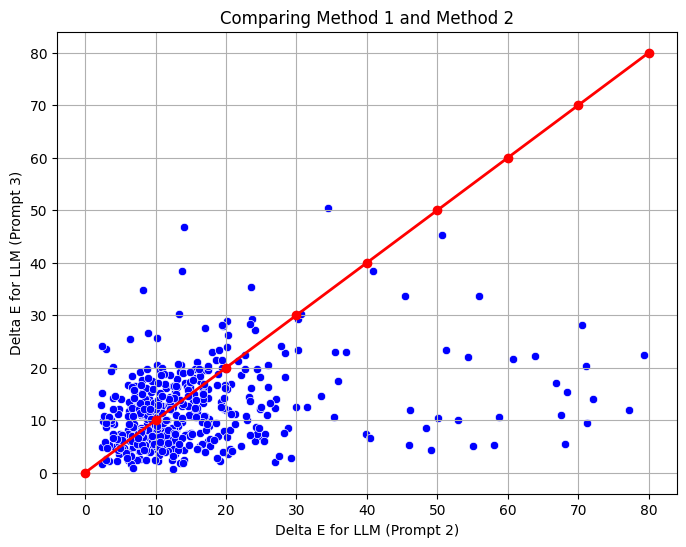

In [ ]:
# Create a scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_val, x=df['diff_llm_lab'], y=df['diff_llm_lab_2'], color='blue')
plt.xlabel('Delta E for LLM (Prompt 2)')
plt.ylabel('Delta E for LLM (Prompt 3)')
plt.title('Comparing Method 1 and Method 2')

# Points for the line
line_x = [0, 10, 20, 30, 40, 50, 60, 70, 80]
line_y = [0, 10, 20, 30, 40, 50, 60, 70, 80]

# Plot the line
plt.plot(line_x, line_y, color='red', linestyle='-', linewidth=2, marker='o')


plt.grid(True)
plt.show()

# Conclusion

The prompt used in the second round improved the results in two significant ways:

Reliability: The number of cases with a Delta E higher than 40 is now nonexistent, demonstrating a marked increase in the consistency and reliability of the color identification.

Accuracy: The prompt refined the accuracy of the model, as 12.85% of the cases that previously had a Delta E above 20 have now shifted to below 20, while only 4.35% of the cases that were below 20 have moved above 20. This results in a net gain of 8% in cases with better color accuracy.

Overall, almost 70% of the cases now have a Delta E below 20, and 50% have a Delta E below 15, indicating a substantial improvement in the model's precision. These enhancements not only reduce significant color discrepancies but also bring the results closer to a level of fidelity that is crucial for applications requiring high accuracy in color representation.

In [ ]:
# Categorize the values
prompt1_below15 = df['diff_llm_lab'].apply(lambda x: 'Below 20' if x < 20 else 'Above 20')
prompt3_below15 = df['diff_llm_lab_2'].apply(lambda x: 'Below 20' if x < 20 else 'Above 20')

# Create the 2x2 table (contingency table)
contingency_table = pd.crosstab(prompt1_below15, prompt3_below15)/len(df)*100

# Display the table
print(round(contingency_table,2))

diff_llm_lab_2  Above 20  Below 20
diff_llm_lab                      
Above 20           13.24     12.85
Below 20            4.35     69.57
